# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [1]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'fungus_Ids.pkl.bz2'
Summaries_file = 'fungus_Summaries.pkl.bz2'
Citations_file = 'fungus_Citations.pkl.bz2'
Abstracts_file = 'fungus_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [4]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [5]:
inverted_index = defaultdict(list)

for id in sorted(Summaries.keys()):
    term_set = set(preprocess(tokenize(Summaries[id].title)))
    if id in Abstracts:
        term_set.update(preprocess(tokenize(Abstracts[id])))
    for term in term_set:
        inverted_index[term].append(id)

tf_matrix = defaultdict(Counter)

for doc_id in Summaries.keys():
    tokens = preprocess(tokenize(Summaries[doc_id].title))
    if (doc_id in Abstracts):
        tokens.extend(preprocess(tokenize(Abstracts[doc_id])))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [6]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [7]:
papers_of_author['Canessa S']

{25154107, 28425998, 29491409, 30868671}

In [8]:
for id in papers_of_author['Canessa S']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [9]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [10]:
print(', '.join( coauthors['Canessa S'] ))

Stegen G, Rouffaer LO, Bossuyt F, Bosman W, Schaub M, Van Praet S, Steinfartz S, Bogaerts S, Kinet T, Pasmans F, Martel A, Haesebrouck F, Schmidt BR, Bert W, Bozzuto C, Spitzen-van der Sluijs A, Janssen N, Adriaensen C, Laudelout A


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Canessa S' and 'Schmidt BR', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Canessa S' as co-author when we look for 'Schmidt BR':

In [11]:
print(', '.join( coauthors['Schmidt BR'] ))

Ducatelle R, Shelton JMG, Wombwell E, Waldman B, Gower DJ, Kolby JE, Blooi M, Fisher MC, Smith F, Toledo LF, Hintz WE, Courtois EA, Zamudio KR, Ghosh P, Bates KA, Sheafor B, Martin MD, Böll S, Nguyen TT, Van Praet S, Doherty-Bone TM, Loyau A, Cunningham AA, Lips KR, Kinet T, Sabino-Pinto J, Woodhams DC, Spikmans F, Salvidio S, Bert W, Webb RJ, Spitzen-van der Sluijs A, Garner TW, Weldon C, Adriaensen C, Briggs CJ, Kerres A, Brookes L, Brankovics B, Stegen G, Bales EK, Minting P, Cashins S, Grassly NC, Doddington BJ, James TY, Veith M, Borgula A, Garner TWJ, Kosch TA, Canessa S, Murray KA, Kirst K, Haesebrouck F, Balloux F, Valenzuela-Sánchez A, Verster R, Fumagalli M, Tobler U, Jenkinson TS, Schmeller DS, Rouffaer LO, Geiger CC, Puschendorf R, Van Bocxlaer I, Vences M, Lin CF, O'Hanlon SJ, Garcia G, Rieux A, Nöllert A, Farrer RA, Meurling S, Spagnoletti M, Tessa G, Speybroeck J, Skerratt LF, Miaud C, Marin da Fonte LF, Oliver JA, Van Rooij P, Lauer A, Pasmans F, Laurila A, Bletz MC, Gi

With that in mind, we can calculate some basic statistics about our graph:

In [12]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  120759
Number of links (co-authorship relations):  708774


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

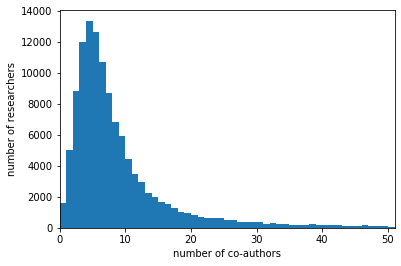

In [13]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [14]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "fungus"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of fungus-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 29907567. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [15]:
paper_id = 29907567
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

3 references found for paper 29907567


{29588468: 'Ras hyperactivation versus overexpression: Lessons from Ras dynamics in Candida albicans.',
 15302823: 'Ectopic expression of URA3 can influence the virulence phenotypes and proteome of Candida albicans but can be overcome by targeted reintegration of URA3 at the RPS10 locus.',
 11722734: 'Ras links cellular morphogenesis to virulence by regulation of the MAP kinase and cAMP signalling pathways in the pathogenic fungus Candida albicans.'}

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [16]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{32102426: 'The Role of Secretory Pathways in <i>Candida albicans</i> Pathogenesis.',
 31440220: '??',
 31186458: '??'}

Paper 31186458, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [17]:
paper_id2 = 31186458
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

4 references identified for the paper with id 31186458


{29907567: 'Ras signaling activates glycosylphosphatidylinositol (GPI) anchor biosynthesis via the GPI-<i>N</i>-acetylglucosaminyltransferase (GPI-GnT) in <i>Candida albicans</i>.',
 15470093: 'Deficiencies in the essential Smp3 mannosyltransferase block glycosylphosphatidylinositol assembly and lead to defects in growth and cell wall biogenesis in Candida albicans.',
 15302823: 'Ectopic expression of URA3 can influence the virulence phenotypes and proteome of Candida albicans but can be overcome by targeted reintegration of URA3 at the RPS10 locus.',
 12101300: 'GPI7 affects cell-wall protein anchorage in Saccharomyces cerevisiae and Candida albicans.'}

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [18]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 54751 (100.00 %)
Number of papers cited at least once: 39069 (71.36 %)
Number of isolated nodes:  13506 (24.67 %)


In [19]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 163671 (100.00 %)
Number of non-isolated nodes: 150165 (91.75 %)
Number of nodes outside our subset: 108920 (66.55 %)


In [20]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 377535 (100.00 %)
Citations outside the subset: 278998 (73.90 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [21]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [22]:
! pip install --user networkx

In [23]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [24]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 150165
Number of edges: 377535
Average in degree:   2.5141
Average out degree:   2.5141
Directed graph: True
Density of graph: 1.6742591114399504e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [25]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [26]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 163671
Number of edges: 377535
Average in degree:   2.3067
Average out degree:   2.3067
Directed graph: True
Density of graph: 1.4093420224626821e-05


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Juan Rodriguez Peinado

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

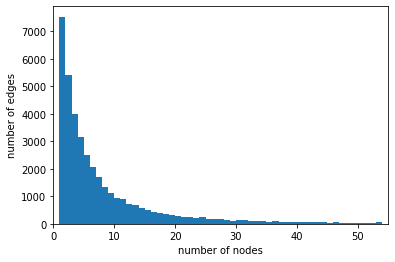

In [27]:
plt.hist( x=[ len(paper) for paper in papers_citing.values() ], bins=range(1,55) )
plt.xlabel('number of nodes')
plt.ylabel('number of edges')
plt.xlim(0,55);

**Answer:** We can observe that few nodes (hub) contain many incoming links, while many nodes contain few incoming links. By the looks of the graph, is similar to an exponential decay as the number decreases at a reate proportional to its current value

### Task 2

Using the [Link Analysis](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`. You can also use the `pagerank_scipy` implementation, which tends to be considerably faster than its regular `pagerank` counterpart, for which you have to install the [SciPy package](http://scipy.org/):

In [28]:
! pip install --user scipy

To test this, create first a list of all papers that are cited by exactly 10 other papers (using `papers_citing` defined above). Then sort these papers by their PageRank and retrieve the paper IDs with the maximum and minimum PageRank values. Print these minimum and maximum PageRank values together with their paper IDs.

To print PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [29]:
# use this:
#pageranks = nx.pagerank(G)
# or this:
pageranks = nx.pagerank_scipy(G)

# Add your code here
citation_10_per_paper = [ (id) for (id,citations) in papers_citing.items() if len(citations) == 10 ]
sorted_10_per_paper = sorted(citation_10_per_paper, key = lambda x: pageranks[x], reverse = True)

id_max_score = sorted_10_per_paper[0]
id_min_score = sorted_10_per_paper[-1]

max_score = pageranks.get(id_max_score)
min_score = pageranks.get(id_min_score)

print ('Max PageRank value: ' + '{:.6f}'.format(max_score) + ', paper ID:', id_max_score )
print ('Max PageRank value: ' + '{:.6f}'.format(min_score) + ', paper ID:', id_min_score )


Max PageRank value: 0.000119, paper ID: 1936991
Max PageRank value: 0.000004, paper ID: 26718720


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

**Answer:** We know that each page is based on two values: authority (links pointing to the page) and hub value (links departing from the page),
given that we can trace back to the code given before in which we can obtain the number of papers in which an ID is being cited.
So we can go back and get the scores of the authorities.



In [30]:
incoming_links_max = { id : Summaries.get(id,['??'])[0] for id in papers_citing[id_max_score]}
for paper in incoming_links_max:
    score_max = pageranks.get(paper)
    num_of_refernces = { id : Summaries[id].title for id in cited_by[paper]}
    print('paper ID:', paper,'number of references', len(num_of_refernces),'with a Pagerank score: ' + '{:.6f}'.format(score_max))



paper ID: 31988806 number of references 24 with a Pagerank score: 0.000003
paper ID: 31052334 number of references 53 with a Pagerank score: 0.000003
paper ID: 23341415 number of references 17 with a Pagerank score: 0.000003
paper ID: 22901238 number of references 1 with a Pagerank score: 0.000003
paper ID: 18575630 number of references 8 with a Pagerank score: 0.000014
paper ID: 14665453 number of references 8 with a Pagerank score: 0.000003
paper ID: 9315680 number of references 4 with a Pagerank score: 0.000003
paper ID: 8889518 number of references 8 with a Pagerank score: 0.000003
paper ID: 8416986 number of references 2 with a Pagerank score: 0.000243
paper ID: 8336695 number of references 2 with a Pagerank score: 0.000020


In [31]:
incoming_links_min = { id : Summaries.get(id,['??'])[0] for id in papers_citing[id_min_score]}
for paper in incoming_links_min:
    score_min = pageranks.get(paper)
    num_of_refernces = { id : Summaries[id].title for id in cited_by[paper]}
    print('paper ID:', paper,'number of references', len(num_of_refernces),'with a Pagerank score: ' + '{:.6f}'.format(score_min))

paper ID: 32670213 number of references 46 with a Pagerank score: 0.000003
paper ID: 32457242 number of references 28 with a Pagerank score: 0.000003
paper ID: 31801308 number of references 43 with a Pagerank score: 0.000003
paper ID: 31376081 number of references 17 with a Pagerank score: 0.000003
paper ID: 30972301 number of references 27 with a Pagerank score: 0.000003
paper ID: 30669450 number of references 20 with a Pagerank score: 0.000003
paper ID: 29237832 number of references 19 with a Pagerank score: 0.000004
paper ID: 29186149 number of references 25 with a Pagerank score: 0.000004
paper ID: 27891121 number of references 35 with a Pagerank score: 0.000004
paper ID: 27814394 number of references 22 with a Pagerank score: 0.000006


**Answer:**  But the numbers of papers that are pointing you are just a mere part of the score, we need to know for each paper the hub and the authority score, and in that way we could understand why there is such a gap between these to papers even if they have the same amount of incoming links.

### Task 4

Copy the scoring function `score_ntn_nnn` from Task 4 of assignment 3. Rename it to `score_ntn_nnn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [32]:
def score_ntn_nnn_pagerank(query_words, doc_id):
    result = 0
    #-
    for i in query_words:
        score = tfidf(i,doc_id)
        #result += 2*(score * pageranks.get(doc_id)) / (score + pageranks.get(doc_id))
        result += score * pageranks.get(doc_id)
    #-
    return (result)


**Answer:** I have decided to get the product of tfidf and pagerank as it looks the only way to obtain scores that are not relatively high, none of them scores 1 or more, we know that tfidf cannot reflect the link information among pages while pagerank does not consider the content of pages. So it might be a good idea to obtain the dot product of both scores. The first formula which is commented, is just obtained from stockoverflow and honestly I have no clue why it has been writen like that. 

### Task 5

Copy the query function `query_ntn_nnn` from Task 4 of assignment 3 (also copy `or_merge`). Rename it to `query_ntn_nnn_pagerank` and change the code to use our new scoring function `score_ntn_nnn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 19741609 as the top result.

In [33]:
def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return (log10(num_documents/ (df(t))))
    
def tfidf(t,d):
    #-
    return (idf(t) * tf(t,d))


def or_merge(sorted_list1, sorted_list2):
    
    list1 = list(sorted_list1)
    list2 = list(sorted_list2)
    #-
    i = 0
    j = 0
    result = []
    #-
    while (i < len(list1) and j < len(list2)):
        if list1[i] == list2[j]:
            result.append(list1[i])
            i +=1
            j +=1
        elif list1[i] <= list2[j]:
            result.append(list1[i])
            i += 1
        else:
            result.append(list2[j])
            j += 1

    remained = list1[i:] + list2[j:]
    result.extend(remained)
    #-
    return (result)

                   
def or_query(a_query):
    merge_list = []
    merge_list = inverted_index[a_query[0]]
    #-
    for word in a_query[1:]:
        merge_list = or_merge(merge_list, inverted_index[word])
    #-
    return (merge_list)

def score_ntn_nnn_pagerank(query_words, doc_id):
    result = 0
    #-
    for i in query_words:
        score = tfidf(i,doc_id)
        #result += 2*(score * pageranks.get(doc_id)) / (score + pageranks.get(doc_id))
        result += score * pageranks.get(doc_id)
   
    return (result)

def query_ntn_nnn_pagerank(query_string):
    elem = preprocess(tokenize(query_string))
    docs_id = or_query(elem)
    final_result = []
    #-
    for doc_id in docs_id:
        result = score_ntn_nnn_pagerank(elem, doc_id)
        final_result .append((result, doc_id))
    return (sorted(final_result , reverse = True)[:10])


query = 'irish potato famine'
search_query = query_ntn_nnn_pagerank(query)  

print(search_query)

for (rank,doc_id) in search_query:
        display_summary(doc_id, show_abstract = True)
        print('Total score is {}'.format(rank))

[(0.014543419636024266, 19741609), (0.002405381175351156, 7972108), (0.0012072573207918583, 11571180), (0.0006201254906755811, 16578829), (0.0005373657069846041, 9885189), (0.0004575915528794751, 11891250), (0.00041088803398998844, 25735453), (0.0003405312209981428, 8673343), (0.00033697950154878834, 16662850), (0.00032060790253910973, 18643983)]


Total score is 0.014543419636024266


Total score is 0.002405381175351156


Total score is 0.0012072573207918583


Total score is 0.0006201254906755811


Total score is 0.0005373657069846041


Total score is 0.0004575915528794751


Total score is 0.00041088803398998844


Total score is 0.0003405312209981428


Total score is 0.00033697950154878834


Total score is 0.00032060790253910973


# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done **individually**, and that code sharing or copying are **strictly forbidden** and will be punished.